In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2023-02-27 23:33:14--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2023-02-27 23:33:14--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf77c5a2a7289d5e1e733a2a753.dl.dropboxusercontent.com/cd/0/inline/B3WLKngWqtV7xof-5XLkVNh7MExxkYSl3SWp1uuWyerTqfFYkc2FXIbYEkhuOx8Cf5znX6lEMiiEr7RAUInZK35zpzbrHNSf_KfjzZfEW14I-QzNCvd4zsoyLVEPIw2_wKonVsRRVe12ljckZ1Bu-TYU5mZycEYfp46w9_4joqLHnw/file# [following]
--2023-02-27 23:33:15--  https://ucf77c5a2a7289d5e1e733a2a753.dl.dropboxusercontent.com/cd/0/inline/B3WLKngWqtV7xof-5XLkVNh7MExxkYSl3SWp1uuWyerTqfFYkc2FXIbYEkhuOx8Cf5znX6lEMiiEr7RAUIn

In [3]:
!unzip -q '/content/archive.zip'

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test/angry/PrivateTest_1054527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test/angry/PrivateTest_10590091.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace test/angry/PrivateTest_10590091.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [32]:
train = Path('/content/train') 
test = Path('/content/test')

In [5]:
train = list(train.glob('*/*'))

train = list(map(lambda x: str(x), train))
train[:5]

['/content/train/angry/Training_62659134.jpg',
 '/content/train/angry/Training_5480720.jpg',
 '/content/train/angry/Training_66823441.jpg',
 '/content/train/angry/Training_13790669.jpg',
 '/content/train/angry/Training_57887477.jpg']

In [6]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_labels = list(map(lambda x : get_label(x) , train))
train_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

Label Encoding

In [7]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
train_labels

array([0, 0, 0, ..., 5, 5, 5])

Converting integers to binary class matrix

In [8]:
train_labels = tf.keras.utils.to_categorical(train_labels)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Splitting Data

In [9]:
from sklearn.model_selection import train_test_split

train, val, train_labels, val_labels = train_test_split(train, train_labels, test_size = .2)

In [10]:
classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8228482, 1: 17.129412, 2: 1.7875998, 3: 1.0, 4: 1.4666331, 5: 1.5076365, 6: 2.3147855}


In [11]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [12]:
IMG_SIZE = 96 
BATCH_SIZE = 32

resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    return dataset

In [14]:
train = get_dataset(train , train_labels)

image , label = next(iter(train))
print(image.shape)
print(label.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(32, 96, 96, 3)
(32, 7)


surprise


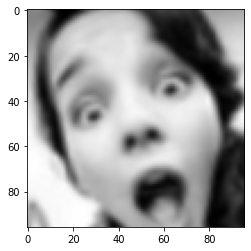

In [15]:
print(encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [16]:
val = get_dataset(val , val_labels , train = False)

image , label = next(iter(val))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


sad


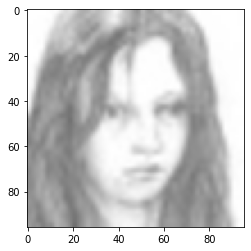

In [17]:
print(encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [25]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)    

In [26]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# Train the model
history = model.fit(
    train,
    steps_per_epoch=len(train)//BATCH_SIZE,
    epochs=30,
    validation_data=val,
    validation_steps = len(val)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/30
22/22 [==============================] - 63s 276ms/step - loss: 3.6667 - accuracy: 0.2287 - val_loss: 1.8795 - val_accuracy: 0.3125
Epoch 2/30
22/22 [==============================] - 3s 139ms/step - loss: 3.2772 - accuracy: 0.2528 - val_loss: 1.7996 - val_accuracy: 0.2875
Epoch 3/30
22/22 [==============================] - 4s 180ms/step - loss: 3.4201 - accuracy: 0.2457 - val_loss: 2.0049 - val_accuracy: 0.2000
Epoch 4/30
22/22 [==============================] - 3s 134ms/step - loss: 3.1942 - accuracy: 0.2955 - val_loss: 1.9717 - val_accuracy: 0.1562
Epoch 5/30
22/22 [==============================] - 3s 136ms/step - loss: 3.4363 - accuracy: 0.3097 - val_loss: 1.9418 - val_accuracy: 0.1688
Epoch 6/30
22/22 [==============================] - 3s 135ms/step - loss: 3.1759 - accuracy: 0.3068 - val_loss: 1.8631 - val_accuracy: 0.1813
Epoch 7/30
22/22 [==============================] - 4s 197ms/step - loss: 2.9828 - accuracy: 0.3494 - val_loss: 1.8268 - val_accuracy: 0.3750
Epoch

Testing Phase

In [33]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test = list(test.glob("*/*"))
test = list(map(lambda x : str(x) , test))
test_labels = list(map(lambda x : get_label(x) , test))

test_labels = encoder.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test = tf.convert_to_tensor(test)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [34]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


angry


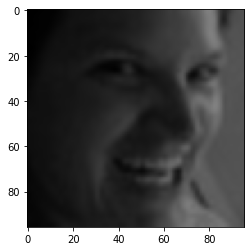

In [35]:
# View a sample Validation Image
print(encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [36]:
# Evaluating the loaded model
loss, acc = model.evaluate(test_dataset)

225/225 [==============================] - 10s 45ms/step - loss: 1.3699 - accuracy: 0.4798
